In [1]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from scipy.sparse import kron, identity, csr_matrix
from scipy.sparse.linalg import eigsh, eigs
from qutip import Qobj, ptrace
from tqdm import tqdm
from matplotlib.ticker import ScalarFormatter

In [2]:
def pauli_x():
    """Pauli X matrix."""
    return np.array([[0, 1], [1, 0]])

def pauli_z():
    """Pauli Z matrix."""
    return np.array([[1, 0], [0, -1]])

def transverse_field_ising(N, J, h,  pbc = False):
    """
    Constructs the Hamiltonian for the transverse field Ising model.
    
    Parameters:
        N (int): Number of spins.
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (scipy.sparse.csr_matrix): The Hamiltonian matrix in sparse format.
    """
    # Sparse identity matrix
    I = identity(2, format="csr")
    
    # Pauli matrices as sparsea
    X = csr_matrix(pauli_x())
    Z = csr_matrix(pauli_z())
    
    # Initialize the Hamiltonian
    H = csr_matrix((2**N, 2**N), dtype=np.float64)
    
    # Interaction term: -J * sigma_i^z * sigma_{i+1}^z
    for i in range(N - 1):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, Z, format="csr")
            elif j == i + 1:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -J * term

    # Add PBC term: interaction between the last site and the first site - for OBC you don't add this term
    if pbc:
        term = 1
        for j in range(N):
            if j == N - 1:
                term = kron(term, Z, format="csr")
            elif j == 0:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -J * term
    else:
        print("Open boundary conditions") 

    
    # Transverse field term: -h * sigma_i^x
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, X, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

def transverse_field_ising_dense(N, J, h, pbc = False):
    """
    Constructs the Hamiltonian for the transverse field Ising model in dense format.
    
    Parameters:
        N (int): Number of spins.
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (np.ndarray): The Hamiltonian matrix in dense format.
    """
    # Pauli matrices
    X = pauli_x()
    Z = pauli_z()
    I = np.eye(2)
    
    # Initialize the Hamiltonian
    H = np.zeros((2**N, 2**N), dtype=np.float64)

    # Interaction term: -J * sigma_i^z * sigma_{i+1}^z
    for i in range(N - 1):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, Z, format="csr")
            elif j == i + 1:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -J * term

    # Add PBC term: interaction between the last site and the first site - for OBC you don't add this term
    if pbc:
        term = 1
        for j in range(N):
            if j == N - 1:
                term = kron(term, Z, format="csr")
            elif j == 0:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -J * term
    else:
        print("Open boundary conditions") 

    # Transverse field term: -h * sigma_i^x
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, X, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

In [3]:
#benchmarking with exact diagonalization

N = 3

J = 1.0  # Interaction strength
h = 1.0  # Transverse field strength

H = transverse_field_ising(N, J, h, pbc = True)
#Hd = H.toarray()
Hd = transverse_field_ising_dense(N, J, h)
eigvals_exact = np.linalg.eigh(Hd)[0]
eigvals_lanczos = eigsh(H, k=(2**N) - 1 , which="SA", return_eigenvectors=False)
print("Exact:", np.sort(eigvals_exact))
print("Lanczos:", np.sort(eigvals_lanczos))

Open boundary conditions
Exact: [-3.49395921 -2.60387547 -1.         -0.10991626  0.10991626  1.
  2.60387547  3.49395921]
Lanczos: [-4.00000000e+00 -3.46410162e+00 -3.07841967e-16 -1.88460346e-16
  6.86148791e-17  2.00000000e+00  2.00000000e+00]


In [4]:
# Example usage
Ns = [14,15]  # Number of spins
J = 1.0  # Interaction strength
h = 1.0  # Transverse field strength

k = 4  # Number of eigenvalues to compute

# Filename to write the eigenvalues
filename = "1D_TFIM_PBC_eigenvalues.txt"

# Open the file in write mode
with open(filename, 'w') as file:
    for N in Ns:
        # Construct the Hamiltonian
        H = transverse_field_ising(N, J, h, pbc = True)

        print(f"Hamiltonian shape for N={N}: {H.shape}")
        print(f"Non-zero elements in H for N={N}: {H.nnz}")

        # Compute the smallest algebraic eigenvalues (ground state) without eigenvectors
        eigvals_sa = eigsh(H, k=k, which='SA', return_eigenvectors=False)

        # Sort the eigenvalues from smallest to largest
        sorted_eigvals = np.sort(eigvals_sa)
        print(f"Sorted Eigenvalues for N={N}:", sorted_eigvals)

        # Write the sorted eigenvalues to the file
        file.write(f"1D TFIM Eigenvalues for N={N}:\n")
        for val in sorted_eigvals:
            file.write(f"{val}\n")
        file.write("\n")

print(f"Eigenvalues written to {filename}")

Hamiltonian shape for N=14: (16384, 16384)
Non-zero elements in H for N=14: 245760
Sorted Eigenvalues for N=14: [-17.86280854 -17.75049095 -16.96709273 -16.86040721]
Hamiltonian shape for N=15: (32768, 32768)
Non-zero elements in H for N=15: 524288
Sorted Eigenvalues for N=15: [-19.13354447 -19.02872891 -18.29731676 -18.19708215]
Eigenvalues written to 1D_TFIM_PBC_eigenvalues.txt


In [5]:
# 3 spins out of 12

N = 12  # Number of spins
J = 1.0  # Interaction strength
h = 1.0  # Transverse field strength

# Assuming transverse_field_ising is defined and returns a sparse Hermitian matrix
H = transverse_field_ising(N, J, h, pbc = True)

#print(f"Hamiltonian shape: {H.shape}")
#print(f"Non-zero elements in H: {H.nnz}")

In [6]:
# ground state of H only + debugging partial trace

# Compute smallest eigenvalue and the corresponding eigenvector
min_eigenvalue, min_eigenvector = eigsh(H, k=1, which='SA')

print(f"Minimum eigenvalue: {min_eigenvalue}")
print(f"Corresponding eigenvector shape: {min_eigenvector.shape}")
#print(f"Corresponding eigenvector: {min_eigenvector}")

#Construct the density matrix
density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())

print(f"Density matrix shape: {density_matrix.shape}")
#print(f"Density matrix: {density_matrix}")

density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])
print(f"qobj density matrix shape: {density_matrix_qobj.shape}")
#print(f"qobj density matrix: {density_matrix_qobj}")

# Trace out some qubits (keep other qubits)
keep_qubits = [0,1,2]  # Indices of qubits to keep
traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

# Convert the result back to a dense matrix if needed
traced_out_density_matrix_dense = traced_out_density_matrix.full()

print(type(traced_out_density_matrix))
print(type(traced_out_density_matrix_dense))

print(f"Traced out density matrix shape: {traced_out_density_matrix_dense.shape}")
#print(f"Traced out density matrix: {traced_out_density_matrix_dense}")

# Diagonalize the traced out density matrix
eigenvalues, eigenvectors = np.linalg.eigh(traced_out_density_matrix_dense)
#print(f"Eigenvalues of the traced out density matrix: {eigenvalues}")
#print(f"Eigenvectors of the traced out density matrix: {eigenvectors}")

# Print the minimum eigenvalue
min_eigenvalue = np.min(eigenvalues)
print(f"Minimum eigenvalue: {min_eigenvalue}")

Minimum eigenvalue: [-15.32259515]
Corresponding eigenvector shape: (4096, 1)
Density matrix shape: (4096, 4096)
qobj density matrix shape: (4096, 4096)
<class 'qutip.core.qobj.Qobj'>
<class 'numpy.ndarray'>
Traced out density matrix shape: (8, 8)
Minimum eigenvalue: 1.424490040821895e-06


In [7]:
#  Lowest 100 eigenvalues of H

# Compute 100 smallest eigenvalues and the corresponding eigenvectors
eigenvalues, eigenvectors = eigsh(H, k=100, which='SA')

min_eigenvalues = []

for i in tqdm(range(100)):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Trace out 9 qubits (keep 3 qubits)
    keep_qubits = [4, 5, 6]  # Indices of qubits to keep
    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

    # Convert the result back to a dense matrix if needed
    traced_out_density_matrix_dense = traced_out_density_matrix.full()

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, _ = np.linalg.eigh(traced_out_density_matrix_dense)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced)
    min_eigenvalues.append(min_eigenvalue)

print("Minimum eigenvalues of the traced-out density matrix:", np.sort(min_eigenvalues))

100%|██████████| 100/100 [00:24<00:00,  4.13it/s]

Minimum eigenvalues of the traced-out density matrix: [1.424490040834912e-06, 2.5882407400161784e-06, 5.1561901482439936e-05, 5.4304185996614154e-05, 1.0091244068361345e-05, 5.42447507485009e-06, 4.1171837659127327e-05, 5.768989998834082e-05, 0.00011523347940258923, 5.144594900612784e-05, 0.00021889096798674757, 0.00023184382730079208, 0.0005605317140146216, 0.0001540729552870305, 8.337745426538811e-05, 0.00010267517320922764, 0.0005744962946040258, 9.131934357808952e-05, 0.0009479287220200838, 0.0003844909427505465, 0.0008773964845391936, 2.0511979513469565e-05, 0.000577757149531434, 4.787241875081755e-05, 0.0013094082426965913, 0.0007101102739710758, 0.00012233595362118915, 0.000196347891048616, 0.0004807245598551348, 0.00021986505577659135, 0.00024380221574763088, 0.003250729800148597, 0.0010447298583056, 0.0011194635837172033, 0.00016729842908366868, 8.747762608620014e-05, 0.00013381868322183716, 0.0009996213028160572, 0.000825163287091436, 0.0006141244346409454, 0.0018626629519330

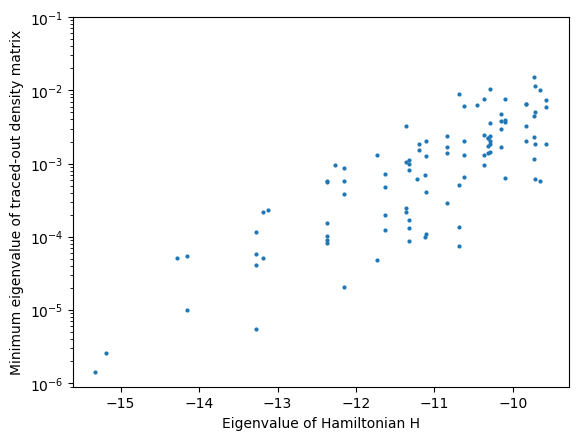

In [8]:
# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.plot(eigenvalues, min_eigenvalues, 'o', markersize=2)

# Set y-scale to log and manually define the ticks
plt.yscale("log")
plt.yticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1], [r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"])

plt.xlabel('Eigenvalue of Hamiltonian H')
plt.ylabel('Minimum eigenvalue of traced-out density matrix')
#plt.title('Minimum eigenvalue of traced-out density matrix vs Eigenvalue of Hamiltonian H')
plt.show()

In [9]:
# All eigenvalues of H

# Compute all eigenvalues and corresponding eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(H.toarray())

min_eigenvalues = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Trace out 9 qubits (keep 3 qubits)
    keep_qubits = [4, 5, 6]  # Indices of qubits to keep
    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

    # Convert the result back to a dense matrix if needed
    traced_out_density_matrix_dense = traced_out_density_matrix.full()

    # Check if the matrix is Hermitian
    is_hermitian = np.allclose(traced_out_density_matrix_dense, traced_out_density_matrix_dense.conj().T)

    # Output the result
    print("The density matrix is Hermitian." if is_hermitian else "The density matrix is not Hermitian.")

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, _ = np.linalg.eigh(traced_out_density_matrix_dense)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced)
    min_eigenvalues.append(min_eigenvalue)

100%|██████████| 4096/4096 [20:01<00:00,  3.41it/s]


In [10]:
print("Minimum eigenvalues of the traced-out density matrix:", np.sort(min_eigenvalues))

Minimum eigenvalues of the traced-out density matrix: [1.42449004e-06 1.42449004e-06 2.58824074e-06 ... 9.64989148e-02
 9.75928035e-02 9.84196626e-02]


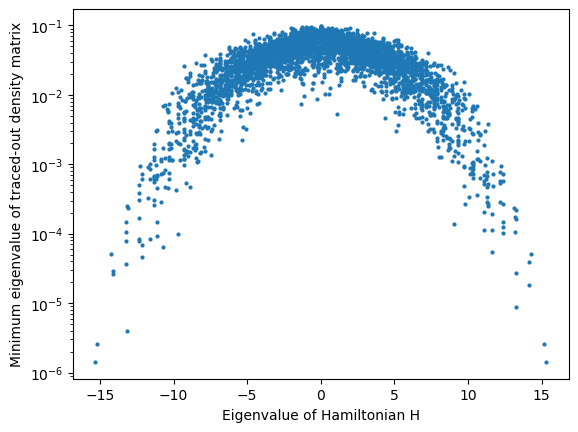

In [11]:
# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.plot(eigenvalues, min_eigenvalues, 'o', markersize=2)

# Set y-scale to log and manually define the ticks
plt.yscale("log")
plt.yticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1], [r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"])

plt.xlabel('Eigenvalue of Hamiltonian H')
plt.ylabel('Minimum eigenvalue of traced-out density matrix')
#plt.title('Minimum eigenvalue of traced-out density matrix vs Eigenvalue of Hamiltonian H')
plt.show()